<a href="https://colab.research.google.com/github/Pyeonseohee/Deeplearning/blob/main/Deepnoid_Lecture05_RNN_and_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple RNN, LSTM으로 Time Series data 다루기

In [3]:
# Window 혹은 권한이 없는 Linux 계정의 경우 GPU memory를 pull하는데에 문제가 발생하는 경우가 종종 발생한다.
# 이를 해결하기 위해 GPU 유무를 체크하고 GPU가 있으면 해당 GPU의 memory 공간을 확보하는 코드
import sys
import numpy as np
import sklearn
import tensorflow as tf
from tensorflow import keras
import os
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt

## For Windows only
## Allow GPU MEMORY GROWTH
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


sin 함수를 기반으로 간단한 단변량 시계열 데이터를 생성해주는 함수와 해당 함수를 사용해서 데이터를 생성

In [4]:
# generate time series data function

def generate_time_series(batch_size, n_steps):
  freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
  time = np.linspace(0, 1, n_steps)
  series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10)) # wave 1
  series +=0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # wave 2
  series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5) # + noise
  return series[..., np.newaxis].astype(np.float32)

In [12]:
# generate data

np.random.seed(42)
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

생성한 시계열 데이터를 그래프로 시각화 해주는 함수

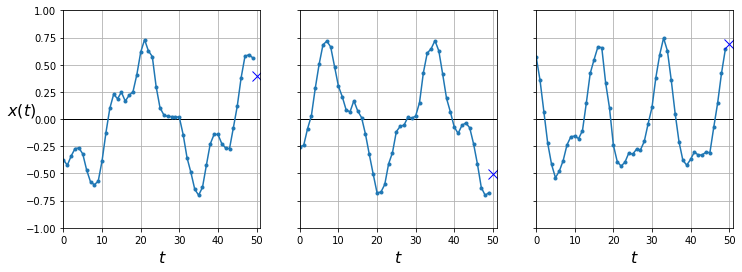

In [14]:
# plot dataset
def plot_series(series, y = None, y_pred = None, x_label = "$t$", y_label = "$x(t)$"):
  plt.plot(series, ".-")
  if y is not None:
    plt.plot(n_steps, y, "bx", markersize = 10)
  if y_pred is not None:
    plt.plot(n_steps, y_pred, "ro")
  plt.grid(True)
  if x_label:
    plt.xlabel(x_label, fontsize = 16)
  if y_label:
    plt.ylabel(y_label, fontsize = 16, rotation = 0)
  plt.hlines(0, 0, 100, linewidth = 1)
  plt.axis([0, n_steps + 1, -1, 1])
fig, axes = plt.subplots(nrows = 1, ncols = 3, sharey = True, figsize = (12, 4))
for col in range(3):
  plt.sca(axes[col])
  plot_series(X_valid[col, :, 0], y_valid[col, 0],
              y_label = ("$x(t)$" if col == 0 else None))
plt.show()

데이터의 순서를 특징 시드 순서로 고정( 데이터가 섞이고 순서가 바뀌는 것을 방지)

단순 Fully Connected Layer를 통해 20 epoch 동안 학습 수행

해달 모델로 forecasting 수행

In [15]:
np.random.seed(42)
tf.random.set_seed(42)

# linear prediction model build
model = keras.models.Sequential([keras.layers.Flatten(input_shape = [50, 1]),
                                 keras.layers.Dense(1)])
model.compile(loss = "mse", optimizer = "adam")

#model train
history = model.fit(X_train, y_train, epochs = 20,
                    validation_data = (X_valid, y_valid))
# model validation
model.evaluate(X_valid, y_valid)

# model prediction
y_pred = model.predict(X_valid)

Epoch 1/20
219/219 [==============================] - 2s 2ms/step - loss: 0.1398 - val_loss: 0.0545
Epoch 2/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0443 - val_loss: 0.0266
Epoch 3/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.0157
Epoch 4/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0142 - val_loss: 0.0116
Epoch 5/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0110 - val_loss: 0.0098
Epoch 6/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0093 - val_loss: 0.0087
Epoch 7/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0083 - val_loss: 0.0079
Epoch 8/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0074 - val_loss: 0.0071
Epoch 9/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0064 - val_loss: 0.0066
Epoch 10/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0063 - val_loss: 0.0062

학습 결과 오프젝트에서 loss 수치를 획득하고 이를 사용해서 x축은 epoch, y축은 loss로 그래프를 그려 loss의 변화를 시각화하는 함수

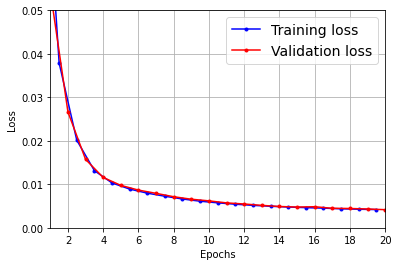

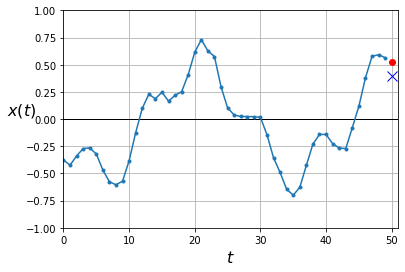

In [17]:
# plot learning curve
def plot_learning_curves(loss, val_loss):
  plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label = "Training loss")
  plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label = "Validation loss")
  plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer = True))
  plt.axis([1, 20, 0, 0.05])
  plt.legend(fontsize = 14)
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

#plot prediction result
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0,0])
plt.show()

FClayer 대신 RNN cell 1개를 써서 같은 데이터를 학습하고 loss 변화를 시각화

Epoch 1/20
219/219 [==============================] - 7s 31ms/step - loss: 0.1554 - val_loss: 0.0489
Epoch 2/20
219/219 [==============================] - 6s 30ms/step - loss: 0.0409 - val_loss: 0.0296
Epoch 3/20
219/219 [==============================] - 6s 30ms/step - loss: 0.0277 - val_loss: 0.0218
Epoch 4/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0208 - val_loss: 0.0177
Epoch 5/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0174 - val_loss: 0.0151
Epoch 6/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0146 - val_loss: 0.0134
Epoch 7/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0138 - val_loss: 0.0123
Epoch 8/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0128 - val_loss: 0.0116
Epoch 9/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0117 - val_lo

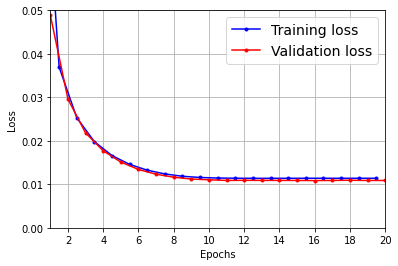

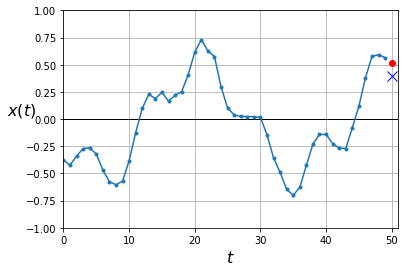

In [19]:
# Using Vanilla RNN
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([keras.layers.SimpleRNN(1, input_shape = [None,1])])
optimizer = keras.optimizers.Adam(lr = 0.005)
model.compile(loss = "mse", optimizer = optimizer)

# model train
history = model.fit(X_train, y_train, epochs =20,
                    validation_data = (X_valid, y_valid))
# model validation
model.evaluate(X_valid, y_valid)

# model prediction
y_pred = model.predict(X_valid)

# plot learning curve
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

#plot prediction result
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

RNN cell을 여러층 쌓아서 깊은 RNN 구조를 만들고 같은 데이터를 학습하고 loss 변화를 시각화

Epoch 1/20
219/219 [==============================] - 22s 94ms/step - loss: 0.1324 - val_loss: 0.0090
Epoch 2/20
219/219 [==============================] - 20s 91ms/step - loss: 0.0078 - val_loss: 0.0065
Epoch 3/20
219/219 [==============================] - 20s 92ms/step - loss: 0.0057 - val_loss: 0.0045
Epoch 4/20
219/219 [==============================] - 20s 90ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 5/20
219/219 [==============================] - 20s 92ms/step - loss: 0.0044 - val_loss: 0.0040
Epoch 6/20
219/219 [==============================] - 20s 93ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 7/20
219/219 [==============================] - 20s 91ms/step - loss: 0.0036 - val_loss: 0.0040
Epoch 8/20
219/219 [==============================] - 20s 92ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 9/20
219/219 [==============================] - 20s 93ms/step - loss: 0.0037 - val_loss: 0.0032
Epoch 10/20
219/219 [==============================] - 20s 93ms/step - loss: 0.003

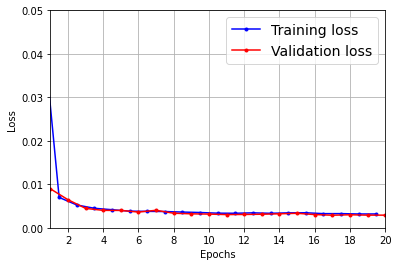

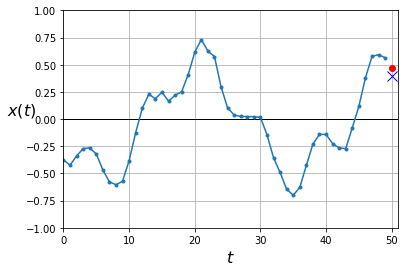

In [21]:
# Using Deep RNN
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([keras.layers.SimpleRNN(20, return_sequences = True, input_shape = [None, 1]),
                                 keras.layers.SimpleRNN(20, return_sequences = True),
                                 keras.layers.SimpleRNN(1)])
model.compile(loss = "mse", optimizer = "adam")

# model train
history = model.fit(X_train, y_train, epochs = 20,
                    validation_data = (X_valid, y_valid))
# model validation
model.evaluate(X_valid, y_valid)

# model prediction
y_pred = model.predict(X_valid)

# plot learning curve
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

# plot prediction result
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

RNN cell을 여러층 쌓아서 깊은 RNN 구조를 만들고 마지막에 FC 레이어를 통해 RNN에서 생성된 feature를 학습하여 forecasting 핟록 만든 신경망으로 같은 데이터를 학습하고 loss변화를 시각화

Epoch 1/20
219/219 [==============================] - 15s 66ms/step - loss: 0.0566 - val_loss: 0.0052
Epoch 2/20
219/219 [==============================] - 14s 64ms/step - loss: 0.0048 - val_loss: 0.0036
Epoch 3/20
219/219 [==============================] - 14s 66ms/step - loss: 0.0036 - val_loss: 0.0031
Epoch 4/20
219/219 [==============================] - 15s 68ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 5/20
219/219 [==============================] - 15s 69ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 6/20
219/219 [==============================] - 15s 69ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 7/20
219/219 [==============================] - 14s 66ms/step - loss: 0.0030 - val_loss: 0.0034
Epoch 8/20
219/219 [==============================] - 14s 65ms/step - loss: 0.0033 - val_loss: 0.0028
Epoch 9/20
219/219 [==============================] - 14s 65ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 10/20
219/219 [==============================] - 14s 64ms/step - loss: 0.002

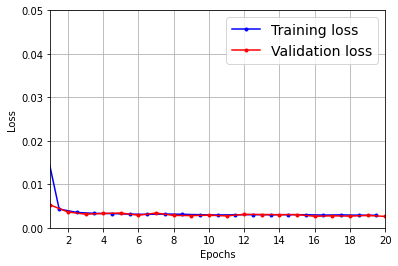

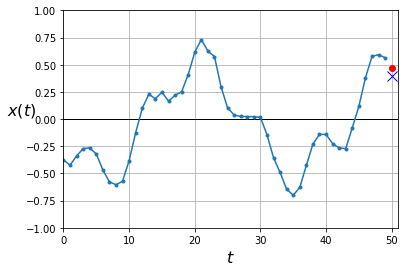

In [22]:
# Using Deep RNN with DNN
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([keras.layers.SimpleRNN(20, return_sequences = True, input_shape = [None, 1]),
                                 keras.layers.SimpleRNN(20),
                                 keras.layers.Dense(1)])
model.compile(loss = "mse", optimizer = "adam")
history = model.fit(X_train, y_train, epochs = 20,
                    validation_data = (X_valid, y_valid))
# model validation
model.evaluate(X_valid, y_valid)

# model prediction
y_pred = model.predict(X_valid)

# plot learning curve
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

# plot prediction result
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

이제 한 시점(step)이 아닌 여러 시점을 forecast함.

우선 이전에 학습했던 모델을 사용해서 1시점씩 10번 예측하여 10시점의 예측 결과를 만들고 해당 결과를 시각화

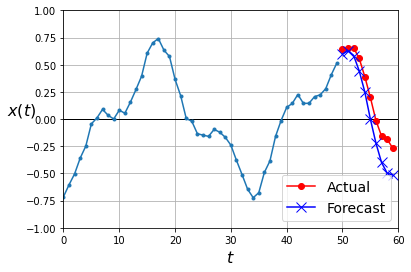

In [25]:
# Forecasting several steps
# forecast 10 step by predicting 1 step that iterate 10 times.
np.random.seed(43) # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
  y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
  X = np.concatenate([X, y_pred_one], axis = 1)

Y_pred = X[:, n_steps:]

def plot_multiple_forecasts(X, Y, Y_pred):
  n_steps = X.shape[1]
  ahead = Y.shape[1]
  plot_series(X[0, :, 0])
  plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label = "Actual")
  plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label = "Forecast", markersize = 10)
  plt.axis([0, n_steps + ahead, -1, 1])
  plt.legend(fontsize = 14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

10시점을 한 번에 예측하기 위한 새로운 데이터 셋을 생성

In [26]:
# Build new dataset for forecast 10 step at onse

np.random.seed(42)
n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
  Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]

Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

RNN cell을 여러층 쌓아 Deep RNN을 만들고 마지막층의 FClayer을 keras.layers.TimeDistributed로 감싼다. FClayer을 감싼 이유는?

Epoch 1/20
219/219 [==============================] - 16s 66ms/step - loss: 0.0705 - last_time_step_mse: 0.2588 - val_loss: 0.0429 - val_last_time_step_mse: 0.2573
Epoch 2/20
219/219 [==============================] - 14s 66ms/step - loss: 0.0413 - last_time_step_mse: 0.2586 - val_loss: 0.0352 - val_last_time_step_mse: 0.2573
Epoch 3/20
219/219 [==============================] - 14s 66ms/step - loss: 0.0332 - last_time_step_mse: 0.2589 - val_loss: 0.0348 - val_last_time_step_mse: 0.2573
Epoch 4/20
219/219 [==============================] - 15s 66ms/step - loss: 0.0306 - last_time_step_mse: 0.2548 - val_loss: 0.0275 - val_last_time_step_mse: 0.2573
Epoch 5/20
219/219 [==============================] - 15s 66ms/step - loss: 0.0279 - last_time_step_mse: 0.2596 - val_loss: 0.0260 - val_last_time_step_mse: 0.2573
Epoch 6/20
219/219 [==============================] - 14s 66ms/step - loss: 0.0258 - last_time_step_mse: 0.2653 - val_loss: 0.0256 - val_last_time_step_mse: 0.2573
Epoch 7/20
219/2

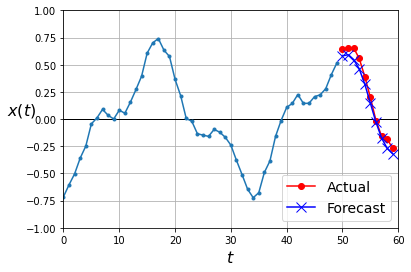

In [28]:
#forecast 10 step at once by using deep RNN
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([keras.layers.SimpleRNN(20, return_sequences = True, input_shape= [None, 1]),
                                 keras.layers.SimpleRNN(20, return_sequences = True),
                                 keras.layers.TimeDistributed(keras.layers.Dense(10))])

def last_time_step_mse(Y_true, T_pred):
  return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss = "mse", optimizer = keras.optimizers.Adam(lr = 0.01), metrics = [last_time_step_mse])
history = model.fit(X_train, Y_train, epochs = 20,
                    validation_data = (X_valid, Y_valid))

np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

keras에서의 custom metric 사용-> last_time_step_mse():

마지막 타임 스텝에서의 Ground truth와 prediction으로 MSE를 계산하는 함수

Y_true와 Y_Pred를 입력받고 keras 함수로 MSE를 계산한 다음 이를 keras에 내장된 epoch별 상태 출력함수에 추가함.

model을 compile해서 build할 때 함수를 추가해주면 매 epoch마다 동작하는 방식

Epoch 1/20
219/219 [==============================] - 15s 62ms/step - loss: 0.0705 - last_time_step_mse: 0.0621 - val_loss: 0.0429 - val_last_time_step_mse: 0.0324
Epoch 2/20
219/219 [==============================] - 13s 61ms/step - loss: 0.0413 - last_time_step_mse: 0.0301 - val_loss: 0.0352 - val_last_time_step_mse: 0.0244
Epoch 3/20
219/219 [==============================] - 13s 62ms/step - loss: 0.0334 - last_time_step_mse: 0.0221 - val_loss: 0.0307 - val_last_time_step_mse: 0.0197
Epoch 4/20
219/219 [==============================] - 13s 61ms/step - loss: 0.0300 - last_time_step_mse: 0.0191 - val_loss: 0.0274 - val_last_time_step_mse: 0.0163
Epoch 5/20
219/219 [==============================] - 13s 62ms/step - loss: 0.0276 - last_time_step_mse: 0.0159 - val_loss: 0.0296 - val_last_time_step_mse: 0.0229
Epoch 6/20
219/219 [==============================] - 13s 61ms/step - loss: 0.0261 - last_time_step_mse: 0.0139 - val_loss: 0.0261 - val_last_time_step_mse: 0.0144
Epoch 7/20
219/2

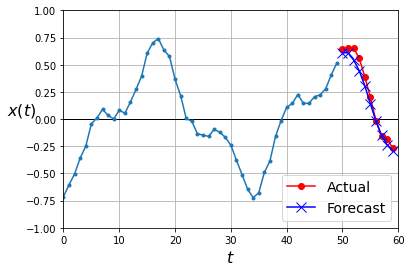

In [29]:
# forecast 10 steps at once by using deep RNN

np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([keras.layers.SimpleRNN(20, return_sequences = True, input_shape = [None, 1]),
                                 keras.layers.SimpleRNN(20, return_sequences = True),
                                 keras.layers.TimeDistributed(keras.layers.Dense(10))])

def last_time_step_mse(Y_true, Y_pred):
  return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss = "mse", optimizer = keras.optimizers.Adam(lr = 0.01), metrics = [last_time_step_mse])
history = model.fit(X_train, Y_train, epochs = 20,
                    validation_data = (X_valid, Y_valid))
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

10 step model을 사용해서 학습하고 한 번에 10 step 예측한 결과

Epoch 1/20
219/219 [==============================] - 15s 64ms/step - loss: 0.0705 - last_time_step_mse: 0.0621 - val_loss: 0.0429 - val_last_time_step_mse: 0.0324
Epoch 2/20
219/219 [==============================] - 14s 63ms/step - loss: 0.0413 - last_time_step_mse: 0.0301 - val_loss: 0.0352 - val_last_time_step_mse: 0.0244
Epoch 3/20
219/219 [==============================] - 14s 63ms/step - loss: 0.0334 - last_time_step_mse: 0.0220 - val_loss: 0.0310 - val_last_time_step_mse: 0.0199
Epoch 4/20
219/219 [==============================] - 14s 63ms/step - loss: 0.0301 - last_time_step_mse: 0.0190 - val_loss: 0.0275 - val_last_time_step_mse: 0.0153
Epoch 5/20
219/219 [==============================] - 14s 63ms/step - loss: 0.0279 - last_time_step_mse: 0.0164 - val_loss: 0.0285 - val_last_time_step_mse: 0.0201
Epoch 6/20
219/219 [==============================] - 14s 63ms/step - loss: 0.0263 - last_time_step_mse: 0.0142 - val_loss: 0.0261 - val_last_time_step_mse: 0.0147
Epoch 7/20
219/2

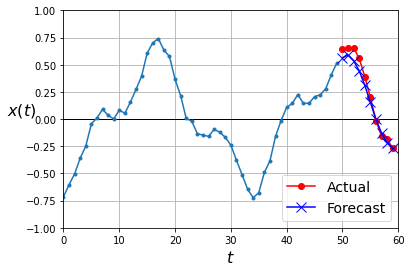

In [33]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([keras.layers.SimpleRNN(20, return_sequences = True, input_shape = [None, 1]),
                                 keras.layers.SimpleRNN(20, return_sequences = True),
                                 keras.layers.TimeDistributed(keras.layers.Dense(10))])

def last_time_step_mse(Y_true, Y_pred):
  return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss = "mse", optimizer = keras.optimizers.Adam(lr = 0.01), metrics = [last_time_step_mse])
history = model.fit(X_train, Y_train, epochs = 20,
                    validation_data = (X_valid, Y_valid))
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

Vanila RNN cell을 LSTM으로 바꾼 뒤 동일한 데이터셋으로 10step 학습 모델 생성

Epoch 1/20
219/219 [==============================] - 4s 11ms/step - loss: 0.0979 - last_time_step_mse: 0.0877 - val_loss: 0.0554 - val_last_time_step_mse: 0.0364
Epoch 2/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0515 - last_time_step_mse: 0.0326 - val_loss: 0.0427 - val_last_time_step_mse: 0.0222
Epoch 3/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0407 - last_time_step_mse: 0.0196 - val_loss: 0.0367 - val_last_time_step_mse: 0.0157
Epoch 4/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0356 - last_time_step_mse: 0.0156 - val_loss: 0.0334 - val_last_time_step_mse: 0.0132
Epoch 5/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0330 - last_time_step_mse: 0.0138 - val_loss: 0.0314 - val_last_time_step_mse: 0.0121
Epoch 6/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0313 - last_time_step_mse: 0.0124 - val_loss: 0.0298 - val_last_time_step_mse: 0.0112
Epoch 7/20
219/219 [=======

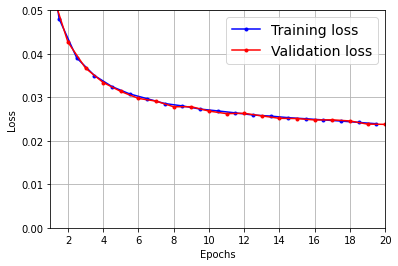

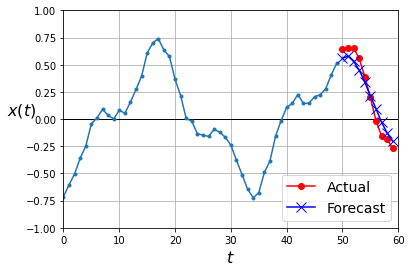

In [35]:
# Deep RNN with DNN using LSTM cell for forecasting next 10 step at each time step
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([keras.layers.LSTM(20, return_sequences = True, input_shape = [None, 1]),
                                 keras.layers.LSTM(20, return_sequences = True),
                                 keras.layers.TimeDistributed(keras.layers.Dense(10))])
model.compile(loss = "mse", optimizer = "adam", metrics = [last_time_step_mse])
history = model.fit(X_train, Y_train, epochs = 20,
                    validation_data = (X_valid, Y_valid))

model.evaluate(X_valid, Y_valid)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

np.random.seed(43)

series = generate_time_series(1, 50+10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()